Using device: cuda

Epoch 001/100
Train [0/50000 (0%)] – loss: 0.0776
Train [6400/50000 (13%)] – loss: 0.0604
Train [12800/50000 (26%)] – loss: 0.0569
Train [19200/50000 (38%)] – loss: 0.0654
Train [25600/50000 (51%)] – loss: 0.0621
Train [32000/50000 (64%)] – loss: 0.0524
Train [38400/50000 (77%)] – loss: 0.0481
Train [44800/50000 (90%)] – loss: 0.0480
Test accuracy: 45.08%
LR after sched: 0.001000

Epoch 002/100
Train [0/50000 (0%)] – loss: 0.0511
Train [6400/50000 (13%)] – loss: 0.0392
Train [12800/50000 (26%)] – loss: 0.0388
Train [19200/50000 (38%)] – loss: 0.0459
Train [25600/50000 (51%)] – loss: 0.0365
Train [32000/50000 (64%)] – loss: 0.0419
Train [38400/50000 (77%)] – loss: 0.0370
Train [44800/50000 (90%)] – loss: 0.0379
Test accuracy: 59.79%
LR after sched: 0.001000

Epoch 003/100
Train [0/50000 (0%)] – loss: 0.0434
Train [6400/50000 (13%)] – loss: 0.0327
Train [12800/50000 (26%)] – loss: 0.0271
Train [19200/50000 (38%)] – loss: 0.0438
Train [25600/50000 (51%)] – loss: 0.0330

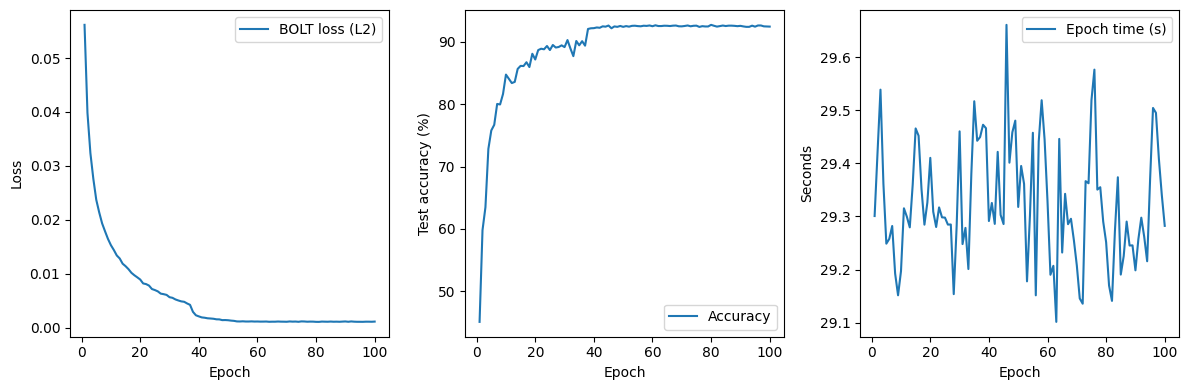


Average epoch time: 29.32 s


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# ───────────────────────────────
# Hyper-parameters & set-up
# ───────────────────────────────
n_epochs           = 100
batch_size_train   = 64
batch_size_test    = 64
learning_rate      = 1e-3
random_seed        = 1
num_classes        = 10

torch.manual_seed(random_seed)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
print(f"Using device: {device}")

# ───────────────────────────────
# Data: CIFAR-10 with augmentation
# ───────────────────────────────
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2430, 0.2610)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.CIFAR10("./cifar10_data", train=True,  download=True, transform=transform_train)
test_ds  = datasets.CIFAR10("./cifar10_data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=batch_size_train, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size_test,  shuffle=False)

# ───────────────────────────────
# Model: ResNet-18 for CIFAR-10
# ───────────────────────────────
def get_resnet18(nc=10):
    m = models.resnet18(pretrained=False)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, nc)
    return m

# ───────────────────────────────
# BOLT loss (L2 version)
# ───────────────────────────────
def BOLT_loss(logits, targets):
    """L2-norm BOLT loss used in place of cross-entropy."""
    probs = F.softmax(logits, dim=1)[:, 1:10]         # drop class-0 as before
    B, C = probs.size()

    class_mask = torch.arange(C, device=targets.device).expand(B, C)
    tgt = targets.unsqueeze(1).expand_as(class_mask)

    loss_mat  = (class_mask >= tgt).float() * probs
    loss_mat += (class_mask == (tgt - 1)).float() * (1.0 - probs)

    return (loss_mat.pow(2).sum() / B)                # L2 penalty

# ───────────────────────────────
# Train / test helpers
# ───────────────────────────────
def train_epoch(model, loader, optimiser):
    model.train()
    running_loss, start = 0.0, time.time()

    for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        optimiser.zero_grad()

        logits = model(x)
        loss = BOLT_loss(logits, y) / num_classes
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Train [{batch_idx * len(x)}/{len(loader.dataset)} "
                  f"({100. * batch_idx / len(loader):.0f}%)] – loss: {loss.item():.4f}")

    return running_loss / len(loader), time.time() - start


@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    acc = 100. * correct / total
    print(f"Test accuracy: {acc:.2f}%")
    return acc

# ───────────────────────────────
# Initialise everything
# ───────────────────────────────
model = get_resnet18(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1,
                              patience=5, verbose=True)

loss_history, acc_history, time_history = [], [], []

# ───────────────────────────────
# Main training loop
# ───────────────────────────────
for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch:03d}/{n_epochs}")
    loss, elapsed = train_epoch(model, train_loader, optimizer)
    acc = test_accuracy(model, test_loader)

    loss_history.append(loss)
    acc_history.append(acc)
    time_history.append(elapsed)

    scheduler.step(acc)
    print(f"LR after sched: {optimizer.param_groups[0]['lr']:.6f}")

# ───────────────────────────────
# Plot
# ───────────────────────────────
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss_history, label="BOLT loss (L2)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, acc_history, label="Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Test accuracy (%)"); plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, time_history, label="Epoch time (s)")
plt.xlabel("Epoch"); plt.ylabel("Seconds"); plt.legend()

plt.tight_layout()
plt.savefig("convergence_l2_BOLT_resnet18_cifar10.png")
plt.show()

print(f"\nAverage epoch time: {np.mean(time_history):.2f} s")